In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import *
from sklearn.linear_model import *
from sklearn.metrics import *
import numpy as np
from sklearn.model_selection import GridSearchCV
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [2]:
train
test.shape
# id 고유 id
# hour 시간
# temperature 기온
# precipitation 비가 오지 않았으면 0, 비가 오면 1 -> int변
# windspeed 풍속(평균)
# humidity 습도
# visibility 특정 기상 상태에 따른 가시성을 의미
# ozone 오존
# pm10 미세먼지(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
# pm2.5 미세먼지(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
# count 시간에 따른 따릉이 대여 수 -> 종속변수

(715, 10)

In [3]:
# train.info()
# for x in [train,test]:
#     x.astype('int64')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


corrgram = train.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corrgram,
            cmap = 'RdYlBu_r')
plt.show()

In [5]:
# 결측치
print(train.isnull().sum())
test.isnull().sum()

id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64


id                         0
hour                       0
hour_bef_temperature       1
hour_bef_precipitation     1
hour_bef_windspeed         1
hour_bef_humidity          1
hour_bef_visibility        1
hour_bef_ozone            35
hour_bef_pm10             37
hour_bef_pm2.5            36
dtype: int64

In [6]:
train[train['hour_bef_temperature'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
934,1420,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0
1035,1553,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


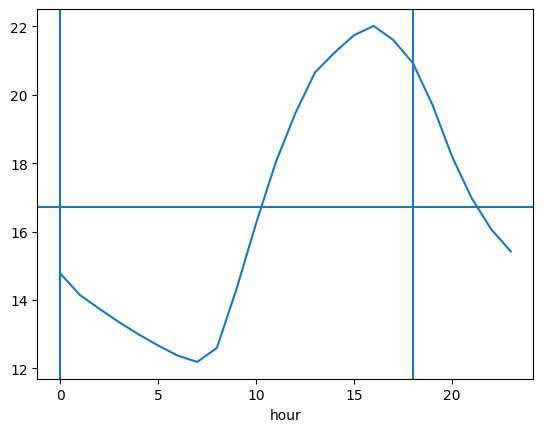

In [7]:
# 0,18시 nan값 채우기. 
# 전체 평균과 격차 큼 -> 시간대 평균 넣어줌
train.groupby('hour').mean()['hour_bef_temperature'].plot()
plt.axhline(train.groupby('hour').mean()['hour_bef_temperature'].mean())
plt.axvline(x=18)
plt.axvline(x=0)

In [8]:
train.groupby('hour').mean()['hour_bef_windspeed']

hour
0     1.965517
1     1.836667
2     1.633333
3     1.620000
4     1.409836
5     1.296721
6     1.331148
7     1.262295
8     1.632787
9     1.829508
10    2.122951
11    2.485246
12    2.766667
13    3.281356
14    3.522951
15    3.768852
16    3.820000
17    3.801667
18    3.838333
19    3.595082
20    3.278333
21    2.755000
22    2.498361
23    2.195082
Name: hour_bef_windspeed, dtype: float64

In [9]:
# 시간대에 평균값 다 넣어주기.

train['hour_bef_temperature'].fillna({934:14.788136,1035:20.926667},inplace=True)
train['hour_bef_precipitation'].fillna({934:0.016949,1035:0.016667},inplace=True)
train['hour_bef_windspeed'].fillna({934:1.965517,1035:3.838333},inplace=True)
train['hour_bef_humidity'].fillna({934:58.169492,1035:40.450000},inplace=True)
train['hour_bef_visibility'].fillna({934:1434.220339,1035:1581.850000},inplace=True)
train['hour_bef_windspeed'].fillna({18:3.281356, 244:1.836667, 260:1.620000, 376:1.965517, 780:3.278333, 934:1.965517, 1035:3.838333, 1138:2.766667, 1229:1.633333},inplace=True)

In [10]:
# ozone 결측치 확인
train[train['hour_bef_ozone'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
14,28,1,20.0,0.0,1.8,58.0,2000.0,NaN,NaN,NaN,74.0
44,76,17,21.7,0.0,3.0,35.0,2000.0,NaN,32.0,19.0,213.0
46,78,1,12.2,0.0,3.0,49.0,1071.0,NaN,NaN,NaN,36.0
84,130,1,9.4,0.0,2.5,65.0,1907.0,NaN,NaN,NaN,39.0
122,181,16,26.2,0.0,4.3,31.0,1718.0,NaN,47.0,23.0,136.0
...,...,...,...,...,...,...,...,...,...,...,...
1283,1941,1,16.6,0.0,2.1,35.0,2000.0,NaN,NaN,NaN,62.0
1322,1994,1,15.1,0.0,1.3,35.0,2000.0,NaN,NaN,NaN,40.0
1329,2005,1,17.7,0.0,1.0,43.0,1338.0,NaN,NaN,NaN,69.0
1361,2047,1,12.6,0.0,2.4,48.0,1805.0,NaN,NaN,NaN,43.0


In [11]:
train['hour_bef_ozone'].fillna(train['hour_bef_ozone'].mean(),inplace=True)
train['hour_bef_pm10'].fillna(train['hour_bef_pm10'].mean(),inplace=True)
train['hour_bef_pm2.5'].fillna(train['hour_bef_pm2.5'].mean(),inplace=True)


In [12]:
# IterativeImputer 결측치 사용
train_df = train.copy()

imputer = IterativeImputer()
df_im = imputer.fit_transform(train_df)
train_df = pd.DataFrame(df_im)

train_df.columns = ('id','hour',
'hour_bef_temperature',
'hour_bef_precipitation',
'hour_bef_windspeed',
'hour_bef_humidity',
'hour_bef_visibility',
'hour_bef_ozone',
'hour_bef_pm10',
'hour_bef_pm2.5',
'count')


In [13]:
train_df.isnull().sum()

id                        0
hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
count                     0
dtype: int64

<AxesSubplot: >

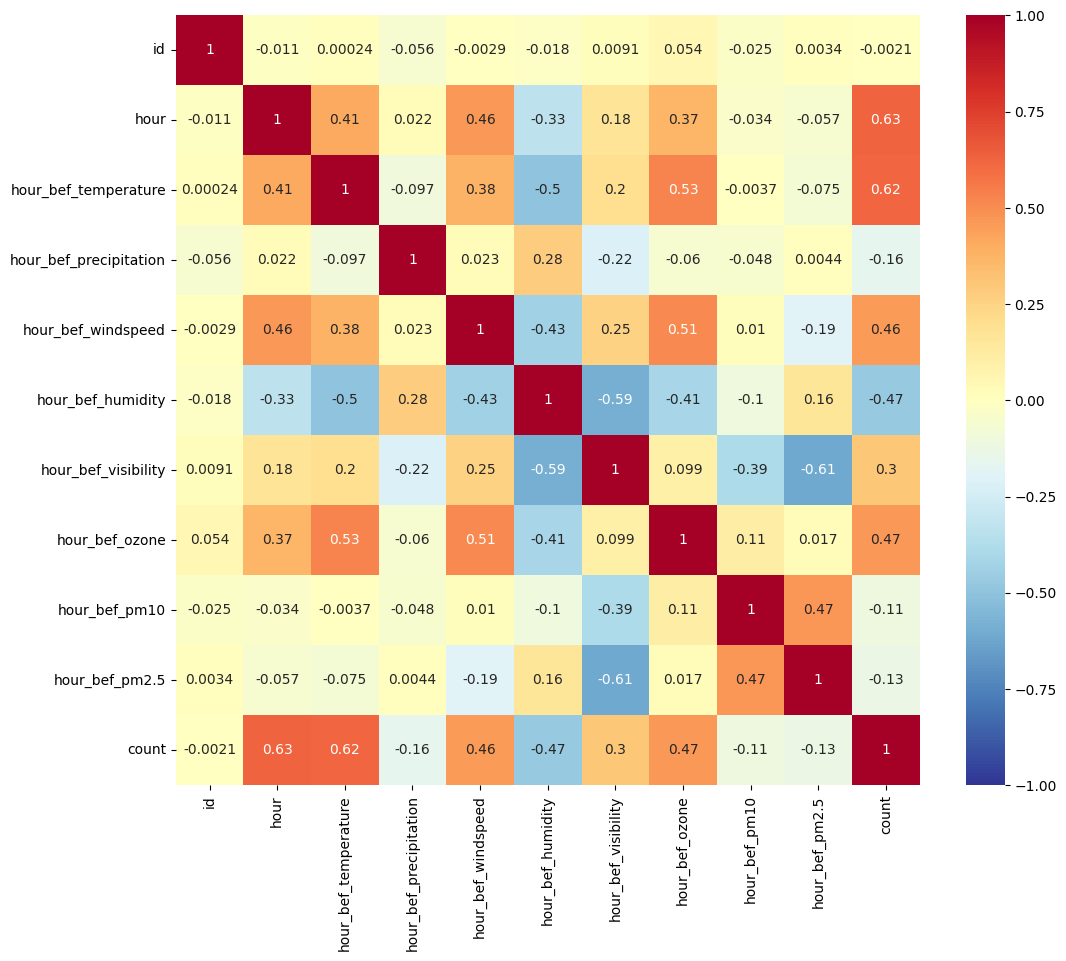

In [14]:
plt.figure(figsize=(12,10))
sns.heatmap(train.corr(),
            annot=True,
            cmap = 'RdYlBu_r',
            vmin = -1, vmax = 1)


In [15]:
ss = StandardScaler()

train_ss = ss.fit_transform(train.iloc[:,:-1])
train_ss = pd.DataFrame(train_ss)
train_ss
train_ss.columns = ('id','hour',
'hour_bef_temperature',
'hour_bef_precipitation',
'hour_bef_windspeed',
'hour_bef_humidity',
'hour_bef_visibility',
'hour_bef_ozone',
'hour_bef_pm10',
'hour_bef_pm2.5',
)


In [16]:
X = train_ss
y = train[['count']]

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1094, 10) (1094, 1) (365, 10) (365, 1)


In [17]:
def model(df):
    df.fit(X_train,y_train)
    y_pred = df.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    print(df,' of rmse',rmse)

model(LogisticRegression())
model(RandomForestClassifier())
model(Ridge())
model(Lasso())
model(DecisionTreeClassifier())
model(LinearRegression())

c:\ProgramData\Anaconda3\envs\pycaret\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression()  of rmse 60.91907949546958


C:\Users\jangmark\AppData\Local\Temp\ipykernel_12132\1321528992.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  df.fit(X_train,y_train)


RandomForestClassifier()  of rmse 51.22550199651069
Ridge()  of rmse 51.98879784233111
Lasso()  of rmse 52.18568913358431
DecisionTreeClassifier()  of rmse 52.575242884684435
LinearRegression()  of rmse 51.985782169725596


In [18]:
Rf = RandomForestClassifier()
Rf.fit(X_train,y_train)
y_pred = Rf.predict(test)

submission = pd.read_csv('submission.csv')
submission['count'] = y_pred

C:\Users\jangmark\AppData\Local\Temp\ipykernel_12132\2292834465.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Rf.fit(X_train,y_train)


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
submission
submission.to_csv('result2.csv',index = False)

In [ ]:
test.isna().sum()

In [ ]:
test[test['hour_bef_windspeed'].isna()]

In [ ]:
print(test.groupby('hour').mean()['hour_bef_humidity'])

In [ ]:
test['hour_bef_visibility'].fillna({653:3.503448},inplace=True)
test['hour_bef_temperature'].fillna({653:26.110345},inplace=True)
test['hour_bef_precipitation'].fillna({653:0.068966},inplace=True)
test['hour_bef_windspeed'].fillna({653:47.689655},inplace=True)
test['hour_bef_humidity'].fillna({653:47.689655},inplace=True)


In [ ]:
test['hour_bef_ozone'].fillna(test['hour_bef_ozone'].mean(),inplace=True)
test['hour_bef_pm10'].fillna(test['hour_bef_pm10'].mean(),inplace=True)
test['hour_bef_pm2.5'].fillna(test['hour_bef_pm2.5'].mean(),inplace=True)


In [ ]:
train_x = train_df.drop(['count'],axis=1)
train_y = train_df[['count']]
test_x = test


In [ ]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(train_x,train_y)
predition = rf.predict(test_x)
predition

In [ ]:
submission = pd.read_csv('submission.csv')
submission


In [ ]:
submission['count'] = predition

In [ ]:
submission.to_csv('result.csv',index = False)